In [28]:
from IterativeBase_Options import *
import numpy as np 
import pandas as pd 
import math 
import scipy as sp
import sympy as smp
import yfinance as yf
from ib_async import *

In [17]:

from scipy.stats import norm

def black_scholes_call(S, K, sigma, r, t):
    d1 = (np.log(S/K) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    C = S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
    return C

black_scholes_call(100, 100, .3, .05, 1)

# The estimated price of a contract using the black-Scholes model. 


np.float64(14.231254785985819)

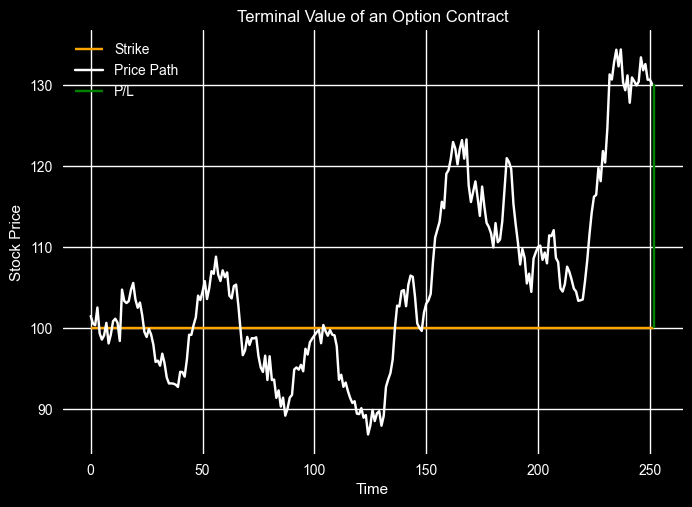

Premium at t=0: 14.231254785985819
P/L: 15.918064816420461


In [19]:
import matplotlib.pyplot as plt
import qfin as qf

# simulate dynamics of the underlying according to Geometric Brownian Motion
path = qf.simulations.GeometricBrownianMotion(100, 0.05, .3, 1/252, 1)


# create a chart of the price path and the strike price
plt.title("Terminal Value of an Option Contract")
plt.hlines(100, 0, 252, label='Strike', color='orange')
plt.plot(path.simulated_path, label='Price Path', color='white')
if max(path.simulated_path[-1] - 100, 0) == 0:
    plt.vlines(252, path.simulated_path[-1], 100, color='red', label="P/L")
else:
    plt.vlines(252, 100, path.simulated_path[-1], color='green', label="P/L")
plt.style.use('dark_background')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# print the premium and the resulting P/L
print("Premium at t=0:", black_scholes_call(100, 100, .3, .05, 1))
print("P/L:", max(path.simulated_path[-1] - 100, 0) - black_scholes_call(100, 100, .3, .05, 1))

# (This part of the code is from Roman Paolucci's QFin library documentation.)

In [20]:
print("Call Price:", black_scholes_call(100, 100, .3, .05, 1))
print("Market Maker Quote:", "13.43 @ 14.10")
print("Trade Edge:", black_scholes_call(100, 100, .3, .05, 1) - 14.10)

Call Price: 14.231254785985819
Market Maker Quote: 13.43 @ 14.10
Trade Edge: 0.13125478598581886


In [21]:
premium = 14.10 * 100
pls = []

for i in range(100000):
    path = qf.simulations.GeometricBrownianMotion(100, 0.05, .3, 1/252, 1)
    pls.append(max(path.simulated_path[-1] - 100, 0)*100 - premium)

np.mean(pls)

# Using GBM to simulate the underlying price path. It simulates 100,000 paths and calculates the average P/L of the option strategy.


np.float64(91.96712276789468)

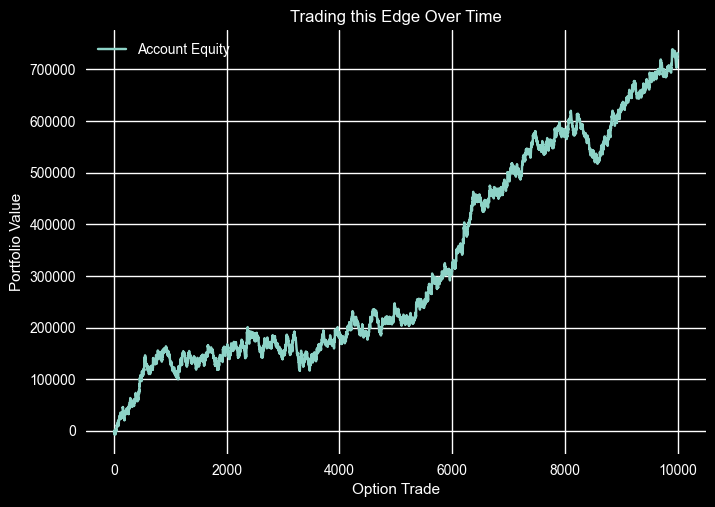

In [22]:
premium = 14.10 * 100
pls = []

for i in range(10000):
    path = qf.simulations.GeometricBrownianMotion(100, 0.05, .3, 1/252, 1)
    pls.append(max(path.simulated_path[-1] - 100, 0)*100 - premium)

plt.title("Trading this Edge Over Time")
plt.plot(np.cumsum(pls), label="Account Equity")
plt.style.use('dark_background')
plt.xlabel('Option Trade')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

In [59]:
# As we saw, this works only in the long-term. Mathmatically, it will approcach positive return over the long run, but you may lose severly in the short term. It makes assumptions, and it must. This is to be carefully considered when trading options using the Black-Scholes model.


In [14]:
from scipy.stats import norm
import numpy as np
import pandas as pd


raw = pd.read_csv("banknifty_20251230_59500_5m.csv")
print(raw)

def black_scholes_call(S, K, sigma, r, t):
    d1 = (np.log(S/K) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    C = S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
    return C

       price  spread   returns
0     609.85  17.650  0.020794
1     622.10  10.250  0.019888
2     606.40  14.200 -0.025561
3     609.05  11.375  0.004361
4     643.00  17.075  0.054244
...      ...     ...       ...
1644  577.75   4.600  0.010527
1645  582.70   4.950  0.008531
1646  583.00   6.275  0.000515
1647  588.00   7.850  0.008540
1648  578.40   7.125 -0.016461

[1649 rows x 3 columns]


In [29]:
import yfinance as yf
import pandas as pd

# Load your options data (with date column)
raw = pd.read_csv("banknifty_20251230_59500_5m.csv", parse_dates=['date'])

# Fetch BankNifty index (^NSEBANK) for the same period, 5‑minute candles
banknifty = yf.download("^NSEBANK", start="2025-11-13", end="2025-12-12", interval="5m")

# Reset index so Datetime is a column
banknifty = banknifty.reset_index()[['Datetime', 'Close']].rename(columns={'Close': 'underlying'})

# Merge on timestamp
# Flatten possible MultiIndex columns, align timezones, then merge underlying into raw
banknifty.columns = [c[0] if isinstance(c, tuple) else c for c in banknifty.columns]
banknifty['Datetime'] = pd.to_datetime(banknifty['Datetime'])
# convert banknifty tz to match raw['date'] tz (if raw has tz)
if raw['date'].dt.tz is not None:
    banknifty['Datetime'] = banknifty['Datetime'].dt.tz_convert(raw['date'].dt.tz)
raw = raw.merge(banknifty[['Datetime', 'underlying']], left_on='date', right_on='Datetime', how='left')

# Drop duplicate Datetime column if desired
raw = raw.drop(columns=['Datetime'])
print(raw.head())

C:\Users\mihir\AppData\Local\Temp\ipykernel_9296\130646786.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  banknifty = yf.download("^NSEBANK", start="2025-11-13", end="2025-12-12", interval="5m")
[*********************100%***********************]  1 of 1 completed

                       date   price  spread   returns    underlying
0 2025-11-13 09:20:00+05:30  609.85  17.650  0.020794  58250.398438
1 2025-11-13 09:25:00+05:30  622.10  10.250  0.019888  58282.800781
2 2025-11-13 09:30:00+05:30  606.40  14.200 -0.025561  58247.851562
3 2025-11-13 09:35:00+05:30  609.05  11.375  0.004361  58270.351562
4 2025-11-13 09:40:00+05:30  643.00  17.075  0.054244  58345.601562


In [109]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# --- Load your aligned dataset ---
# Columns required: date, price, spread, returns, underlying
raw = pd.read_csv("banknifty_20251230_59500_5m.csv", parse_dates=['date'])

# --- Config ---
K = 59500          # Strike inferred from filename
r = 0.05           # Risk-free (annual); adjust if you have local rate
sigma = 0.25      # Implied vol (annual); can be calibrated later
expiry = pd.Timestamp("2025-12-30 15:30:00+05:30")  # Market close at expiry

# --- Time to expiry per row (in years) ---
# Clamp t to a small positive floor to avoid div-by-zero in Black–Scholes
dt = (expiry.tz_convert(None) if expiry.tzinfo else expiry)  # normalize tz
raw['t_years'] = (dt - raw['date'].dt.tz_convert(None)).dt.total_seconds() / (365 * 24 * 3600)
raw['t_years'] = raw['t_years'].clip(lower=1e-6)

# --- Black–Scholes call (vectorized) ---
def black_scholes_call_vectorized(S, K, sigma, r, t):
    # Avoid invalid values
    S = np.maximum(S, 1e-8)
    K = max(K, 1e-8)
    t = np.maximum(t, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return S * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)

# ensure 'underlying' is present (try merge from `banknifty` if needed) and compute theo_price only where available
if 'underlying' not in raw.columns or raw['underlying'].isna().all():
    if 'banknifty' in globals():
        bn = banknifty.copy()
        if 'Datetime' in bn.columns:
            bn = bn.rename(columns={'Datetime': 'date'})
        bn['date'] = pd.to_datetime(bn['date'])
        raw = raw.merge(bn[['date', 'underlying']], on='date', how='left', suffixes=('', '_bn'))
        if 'underlying_bn' in raw.columns:
            raw['underlying'] = raw.get('underlying').fillna(raw['underlying_bn'])
            raw.drop(columns=['underlying_bn'], inplace=True)

mask = raw['underlying'].notna()
raw.loc[mask, 'theo_price'] = black_scholes_call_vectorized(
    raw.loc[mask, 'underlying'].values, K, sigma, r, raw.loc[mask, 't_years'].values
)
raw.loc[~mask, 'theo_price'] = np.nan

# --- Mispricing and base signal ---
raw['price_diff'] = raw['theo_price'] - raw['price']

# Thresholds
mispricing_thr = 0.1          # actionable mispricing threshold
max_spread = raw['spread'].quantile(0.90)  # skip the widest 10% spreads
last_day_cut = 1.0 / 252      # avoid trading in final ~1 trading day

# --- Base signal ---
# Relative mispricing as percentage
raw['mispricing_pct'] = (raw['theo_price'] - raw['price']) / raw['theo_price']

# Base signal: Buy if underpriced, Sell if overpriced
raw['signal'] = np.where(raw['mispricing_pct'] > mispricing_thr, 1,
                 np.where(raw['mispricing_pct'] < -mispricing_thr, -1, 0))

# Filters
raw['signal'] = np.where((raw['spread'] <= max_spread) & (raw['t_years'] > last_day_cut),
                         raw['signal'], 0)
raw['signal'] = np.where(raw['price'] > 0.5, raw['signal'], 0)

# Optional: keep flips only
# raw['signal'] = raw['signal'].where(raw['signal'].diff().fillna(0) != 0, 0)



# --- PnL proxy ---
# Use returns as the next-step move of option price; apply side and subtract spread cost
# Cost model: half-spread as slippage per trade direction change
half_spread_cost = 0.5

raw['pnl'] = raw['signal'] * raw['returns'] - (np.abs(raw['signal'].diff().fillna(0)) * half_spread_cost * raw['spread'])

# --- Summary outputs ---
cols = ['date', 'price', 'spread', 'returns', 'underlying', 't_years', 'theo_price', 'price_diff', 'signal', 'pnl']
print(raw[cols].head())

# Equity curve and aggregate metrics
equity = raw['pnl'].cumsum()


# This also saves a CSV files with all the calculation, making it easy for working with several strategies or with IterativeBacktest.
raw.to_csv("blackscholes_backtest.csv", index=False)

                       date   price  spread   returns    underlying   t_years  \
0 2025-11-13 09:20:00+05:30  609.85  17.650  0.020794  58250.398438  0.129471   
1 2025-11-13 09:25:00+05:30  622.10  10.250  0.019888  58282.800781  0.129462   
2 2025-11-13 09:30:00+05:30  606.40  14.200 -0.025561  58247.851562  0.129452   
3 2025-11-13 09:35:00+05:30  609.05  11.375  0.004361  58270.351562  0.129443   
4 2025-11-13 09:40:00+05:30  643.00  17.075  0.054244  58345.601562  0.129433   

    theo_price   price_diff  signal       pnl  
0  1700.642696  1090.792696       1  0.020794  
1  1715.260583  1093.160583       1  0.019888  
2  1699.314189  1092.914189       1 -0.025561  
3  1709.424897  1100.374897       1  0.004361  
4  1743.723489  1100.723489       1  0.054244  


In [122]:
import pandas as pd
import numpy as np

def compute_indicators(df, sma_fast=10, sma_slow=30, rsi_period=14):
    # --- SMA ---
    df['SMA_fast'] = df['price'].rolling(sma_fast).mean()
    df['SMA_slow'] = df['price'].rolling(sma_slow).mean()

    # --- SMA crossover flags ---
    df['trend_up'] = (df['SMA_fast'] > df['SMA_slow']) & (df['SMA_fast'].shift(1) <= df['SMA_slow'].shift(1))
    df['trend_down'] = (df['SMA_fast'] < df['SMA_slow']) & (df['SMA_fast'].shift(1) >= df['SMA_slow'].shift(1))

    # --- RSI ---
    delta = df['price'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(rsi_period).mean()
    avg_loss = loss.rolling(rsi_period).mean().replace(0, 1e-9)
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df.dropna()


class CSVBacktester:
    def __init__(self, csv_file, amount=100000, use_spread=True):
        self.data = pd.read_csv(csv_file, parse_dates=['date'])
        self.data.set_index('date', inplace=True)
        self.initial_balance = amount
        self.current_balance = amount
        self.use_spread = use_spread
        self.units = 0
        self.trades = 0
        self.position = 0
        self.entry_price = None

    # --- helper functions ---
    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        spread = round(self.data.spread.iloc[bar], 5)
        return date, price, spread

    def print_current_balance(self, bar):
        date, price, spread = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 2)))

    def buy_instrument(self, bar, units=None, amount=None):
        date, price, spread = self.get_values(bar)
        if self.use_spread:
            price += spread/2
        if amount is not None:
            units = int(amount / price)
        self.current_balance -= units * price
        self.units += units
        self.trades += 1
        print("{} |  Buying {} for {}".format(date, units, round(price, 5)))

    def sell_instrument(self, bar, units=None, amount=None):
        date, price, spread = self.get_values(bar)
        if self.use_spread:
            price -= spread/2
        if amount is not None:
            units = int(amount / price)
        self.current_balance += units * price
        self.units -= units
        self.trades += 1
        print("{} |  Selling {} for {}".format(date, units, round(price, 5)))

    def print_current_position_value(self, bar):
        date, price, spread = self.get_values(bar)
        cpv = self.units * price
        print("{} |  Current Position Value = {}".format(date, round(cpv, 2)))

    def print_current_nav(self, bar):
        date, price, spread = self.get_values(bar)
        nav = self.current_balance + self.units * price
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))

    def close_pos(self, bar):
        date, price, spread = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        self.current_balance += self.units * price
        self.current_balance -= (abs(self.units) * spread/2 * self.use_spread)
        print("{} | closing position of {} for {}".format(date, self.units, price))
        self.units = 0
        self.trades += 1
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2)))
        print("{} | number of trades executed = {}".format(date, self.trades))
        print(75 * "-")

    # --- SMA + RSI strategy with TP/SL ---
    def run_sma_rsi_strategy(self, sma_fast=10, sma_slow=30, rsi_period=14,
                             take_profit=0.20, stop_loss=0.10):
        print("-" * 75)
        print(f"Running SMA+RSI strategy | TP={take_profit*100:.0f}% | SL={stop_loss*100:.0f}%")
        print("-" * 75)

        # compute indicators
        self.data = compute_indicators(self.data, sma_fast, sma_slow, rsi_period)

        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_balance
        self.entry_price = None

        for bar in range(len(self.data)-1):
            sig = int(self.data.signal.iloc[bar])
            rsi_val = self.data.RSI.iloc[bar]
            price = self.data.price.iloc[bar]
            trend_up = self.data.trend_up.iloc[bar]
            trend_down = self.data.trend_down.iloc[bar]

            # --- Entry rules with SMA crossover + RSI zone ---
            if sig == 1 and trend_up and 40 <= rsi_val <= 80 and self.position <= 0:
                risk_fraction = 1.0  # 5% of balance per trade
                trade_amount = self.current_balance * risk_fraction
                self.buy_instrument(bar, amount=trade_amount)
                self.position = 1
                self.entry_price = price

            elif sig == -1 and trend_down and 40 <= rsi_val <= 80 and self.position >= 0:
                risk_fraction = 1.0
                trade_amount = self.current_balance * risk_fraction
                self.sell_instrument(bar, amount=trade_amount)
                self.position = -1
                self.entry_price = price

            # --- Exit rules ---
            if self.position == 1 and self.entry_price:
                if (price - self.entry_price)/self.entry_price >= take_profit:
                    self.sell_instrument(bar, units=self.units)
                    self.position = 0
                    self.entry_price = None
                elif (price - self.entry_price)/self.entry_price <= -stop_loss:
                    self.sell_instrument(bar, units=self.units)
                    self.position = 0
                    self.entry_price = None

            elif self.position == -1 and self.entry_price:
                if (self.entry_price - price)/self.entry_price >= take_profit:
                    self.buy_instrument(bar, units=-self.units)
                    self.position = 0
                    self.entry_price = None
                elif (self.entry_price - price)/self.entry_price <= -stop_loss:
                    self.buy_instrument(bar, units=-self.units)
                    self.position = 0
                    self.entry_price = None

        # close any open position at the end
        self.close_pos(len(self.data)-1)


In [123]:
bt = CSVBacktester("blackscholes_backtest.csv", amount=100000)
bt.run_sma_rsi_strategy(sma_fast=10, sma_slow=30, rsi_period=14, take_profit=0.20, stop_loss=0.2)


---------------------------------------------------------------------------
Running SMA+RSI strategy | TP=20% | SL=20%
---------------------------------------------------------------------------
2025-11-13 |  Buying 138 for 721.675
2025-11-18 |  Selling 138 for 860.1625
2025-11-18 |  Buying 138 for 861.275
2025-11-24 |  Selling 138 for 678.575
2025-11-25 |  Buying 130 for 719.4625
2025-11-26 |  Selling 130 for 887.5625
2025-11-27 |  Buying 114 for 1012.0875
2025-12-01 |  Selling 114 for 1215.4625
2025-12-01 |  Buying 138 for 1005.5625
2025-12-02 |  Selling 138 for 781.9125
2025-12-03 |  Buying 162 for 664.8375
2025-12-03 |  Selling 162 for 787.675
2025-12-04 |  Buying 181 for 706.4625
2025-12-05 |  Selling 181 for 841.2125
2025-12-08 |  Buying 236 for 645.1625
2025-12-10 |  Selling 236 for 487.45
2025-12-10 |  Buying 231 for 496.8125
2025-12-11 |  Selling 231 for 631.4375
---------------------------------------------------------------------------
2025-12-11 | +++ CLOSING FINAL POSITION

46% are great returns, especially over a 1 month period. Further backtesting can be done to evaluate performance. But that's for another day!